In [19]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder



# PreProcessing Data

In [20]:

from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/finalMergedData.csv'
df = pd.read_csv(file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Delete the features that we are able to acess before the play starts, including passResult, passLength, penaltyYards, playNullifiedByPenalty, passPossibility

In [21]:
# Add features to delete
features_to_delete = ['passResult', 'passProbability','prePenaltyPlayResult', 'penaltyYards', 'playNullifiedByPenalty', 'foulName1', 'foulName2', 'foulNFLId1', 'foulNFLId2', 'homeTeamWinProbabilityAdded', 'visitorTeamWinProbilityAdded','expectedPointsAdded' ]
# Drop the unwanted features
df = df.drop(features_to_delete, axis=1)

In [22]:
# delete a few descriptive features:
Features_to_delete = ['playDescription', 'gameId', 'ballCarrierId', 'ballCarrierDisplayName', 'collegeName', 'Full Name', 'Team']
df = df.drop(Features_to_delete, axis=1)

In [23]:
column_data_types = df.dtypes
print(column_data_types)

playId                                int64
quarter                               int64
down                                  int64
yardsToGo                             int64
possessionTeam                       object
defensiveTeam                        object
yardlineSide                         object
yardlineNumber                        int64
gameClock                            object
preSnapHomeScore                      int64
preSnapVisitorScore                   int64
passLength                          float64
playResult                            int64
absoluteYardlineNumber                int64
offenseFormation                     object
defendersInTheBox                   float64
preSnapHomeTeamWinProbability       float64
preSnapVisitorTeamWinProbability    float64
expectedPoints                      float64
frameId                               int64
playDirection                        object
x                                   float64
y                               

In [24]:
# Combine all unique values from the relevant columns into one list
unique_teams = pd.unique(df[['possessionTeam', 'defensiveTeam', 'yardlineSide']].values.ravel('K'))

# Create a label encoder object
label_encoder = LabelEncoder()

# Fit the label encoder on the unique values
label_encoder.fit(unique_teams)

# Transform each column with the fitted label encoder
df['possessionTeam'] = label_encoder.transform(df['possessionTeam'])
df['defensiveTeam'] = label_encoder.transform(df['defensiveTeam'])
df['yardlineSide'] = label_encoder.transform(df['yardlineSide'])
df['offenseFormation'] = label_encoder.fit_transform(df['offenseFormation'])
df['Position'] = label_encoder.fit_transform(df['Position'])
df['playDirection'] = label_encoder.fit_transform(df['playDirection'])

In [25]:
df['playDirection']

0        0
1        1
2        1
3        1
4        1
        ..
11343    1
11344    0
11345    1
11346    1
11347    1
Name: playDirection, Length: 11348, dtype: int64

In [26]:


# df = pd.get_dummies(df, columns=['possessionTeam', 'defensiveTeam', 'yardlineSide', 'offenseFormation', 'Position', 'playDirection'])
def clock_to_minutes(time_str):
    hours, minutes = map(int, time_str.split(':'))
    return hours * 60 + minutes
def height_to_cm(height):
    feet, inches = height.split('-')
    return int(feet) * 30.48 + int(inches) * 2.54
# Apply this function to each entry in the 'gameClock' column
df['gameClock'] = df['gameClock'].apply(clock_to_minutes)
df['height_x'] = df['height_x'].apply(height_to_cm)

df

,playId,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,...,x,y,distanceToEndZone,height_x,weight_x,Position,yearsPro,overall_rating,teamId,age
0,3537,4,1,10,1,29,1,41,472,21,...,63.87,29.23,63.87,190.50,261,7,2.0,52.0,14.0,27.0
1,121,1,3,4,1,22,1,42,821,0,...,52.77,26.42,67.23,190.50,261,7,2.0,52.0,14.0,27.0
2,1217,2,4,1,1,16,16,13,330,14,...,101.06,8.47,18.94,190.50,261,7,2.0,52.0,14.0,27.0
3,749,1,2,14,1,7,7,35,131,3,...,91.15,51.02,28.85,190.50,261,7,2.0,52.0,14.0,27.0
4,959,2,2,7,1,4,1,49,820,0,...,66.42,39.05,53.58,190.50,261,7,2.0,52.0,14.0,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11343,3088,3,2,6,3,15,3,29,125,17,...,38.12,19.84,81.88,195.58,251,7,3.0,64.0,3.0,27.0
11344,2612,3,1,10,9,13,9,25,531,6,...,93.12,23.99,93.12,182.88,225,2,3.0,63.0,27.0,25.0
11345,1204,2,2,7,8,23,23,14,598,3,...,99.29,14.20,20.71,190.50,195,8,0.0,71.0,11.0,23.0
11346,2064,3,2,10,13,14,13,34,536,17,...,47.00,15.72,73.00,193.04,220,8,2.0,64.0,10.0,24.0


In [27]:
df['defendersInTheBox'] = df['defendersInTheBox'].fillna(df['defendersInTheBox'].mean())
df['passLength'] = df['passLength'].fillna(df['defendersInTheBox'].mean())
# Check if any row has at least one missing value
# Check if any row has at least one missing value
rows_with_missing_values = df.isnull().any(axis=1)
sum(rows_with_missing_values)
scaler = StandardScaler()

# Fit the scaler to the data and transform the data
categorical_features = ['possessionTeam', 'defensiveTeam', 'yardlineSide', 'offenseFormation', 'Position']

# List of columns to exclude from standardization (including target and any non-features)
excluded_columns = ['playResult', 'passLength'] + categorical_features

# Creating the list of columns to standardize by excluding the specified columns
columns_to_standardize = [col for col in df.columns if col not in excluded_columns]

# Subset the DataFrame to include only the columns to standardize
df_subset = df[columns_to_standardize]
df_standardized = scaler.fit_transform(df_subset)
df_subset = pd.DataFrame(df_standardized, columns=df_subset.columns)
df[columns_to_standardize] = df_subset
df

,playId,quarter,down,yardsToGo,possessionTeam,defensiveTeam,yardlineSide,yardlineNumber,gameClock,preSnapHomeScore,...,x,y,distanceToEndZone,height_x,weight_x,Position,yearsPro,overall_rating,teamId,age
0,1.323072,1.274946,-0.918198,0.397173,1,29,1,0.915164,0.113727,1.025407,...,0.143207,0.247832,0.027177,0.977365,2.277991,7,-0.669202,-3.014546,-0.201423,0.548816
1,-1.588305,-1.361688,1.588349,-1.126446,1,22,1,0.995623,1.416317,-1.193672,...,-0.310287,-0.046835,0.165632,0.977365,2.277991,7,-0.669202,-3.014546,-0.201423,0.548816
2,-0.654210,-0.482810,2.841622,-1.888255,1,16,16,-1.337696,-0.416266,0.285714,...,1.662616,-1.929143,-1.824240,0.977365,2.277991,7,-0.669202,-3.014546,-0.201423,0.548816
3,-1.053075,-1.361688,0.335075,1.412919,1,7,7,0.432408,-1.159003,-0.876660,...,1.257740,2.532818,-1.415882,0.977365,2.277991,7,-0.669202,-3.014546,-0.201423,0.548816
4,-0.874097,-0.482810,0.335075,-0.364636,1,4,1,1.558838,1.412585,-1.193672,...,0.247388,1.277596,-0.396840,0.977365,2.277991,7,-0.669202,-3.014546,-0.201423,0.548816
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11343,0.940400,0.396068,0.335075,-0.618573,3,15,3,-0.050347,-1.181397,0.602726,...,-0.908818,-0.736840,0.769310,1.743698,1.760168,7,-0.257731,-1.728845,-1.397013,0.548816
11344,0.534716,0.396068,-0.918198,0.397173,9,13,9,-0.372184,0.333936,-0.559649,...,1.338225,-0.301655,1.232473,-0.172135,0.413829,2,-0.257731,-1.835987,1.211546,-0.221733
11345,-0.665290,-0.482810,0.335075,-0.364636,8,23,23,-1.257237,0.584003,-0.876660,...,1.590302,-1.328273,-1.751304,0.977365,-1.139639,8,-1.492143,-0.978853,-0.527493,-0.992282
11346,0.067668,0.396068,0.335075,0.397173,13,14,13,0.351949,0.352598,0.602726,...,-0.546022,-1.168880,0.403395,1.360531,0.154918,8,-0.669202,-1.728845,-0.636183,-0.607007


In [28]:
df.columns

Index(['playId', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passLength', 'playResult',
       'absoluteYardlineNumber', 'offenseFormation', 'defendersInTheBox',
       'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability',
       'expectedPoints', 'frameId', 'playDirection', 'x', 'y',
       'distanceToEndZone', 'height_x', 'weight_x', 'Position', 'yearsPro',
       'overall_rating', 'teamId', 'age'],
      dtype='object')

In [29]:
import pandas as pd
import seaborn as sns


# Assuming df is your DataFrame and 'playResult' is your target variable
X = df.drop(['playResult','passLength'], axis=1) # Features
y_final = df['playResult'] # Target variable
y_aux = df['passLength']

# Correlation analysis
# correlation_matrix = df.corr()
# print(correlation_matrix['playResult'].sort_values(ascending=False))
# plt.figure(figsize=(30,20))
# sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
# plt.show()


In [30]:
# frameId is unrealeted, decide to delete it
df = df.drop('frameId', axis=1)

In [31]:
X.dtypes

playId                              float64
quarter                             float64
down                                float64
yardsToGo                           float64
possessionTeam                        int64
defensiveTeam                         int64
yardlineSide                          int64
yardlineNumber                      float64
gameClock                           float64
preSnapHomeScore                    float64
preSnapVisitorScore                 float64
absoluteYardlineNumber              float64
offenseFormation                      int64
defendersInTheBox                   float64
preSnapHomeTeamWinProbability       float64
preSnapVisitorTeamWinProbability    float64
expectedPoints                      float64
frameId                             float64
playDirection                       float64
x                                   float64
y                                   float64
distanceToEndZone                   float64
height_x                        

# Split data into trainig, validation and test sets

In [32]:

# Let's say you have y_aux as your auxiliary target (intermediary play result)
# and y_final as your final target to predict

# First, you split your data into training and a temporary set (combining validation and test)
X_train, X_temp, y_aux_train, y_aux_temp, y_final_train, y_final_temp = train_test_split(
    X, y_aux, y_final, test_size=0.4, random_state=42
)

# Now split the temporary set further into validation and test sets for both auxiliary and final targets
X_val, X_test, y_aux_val, y_aux_test, y_final_val, y_final_test = train_test_split(
    X_temp, y_aux_temp, y_final_temp, test_size=0.5, random_state=42
)


In [33]:
X_train['Position'].nunique()

9

In [37]:
X_train['expectedPoints']

2726     1.593335
477     -0.682752
1329    -0.600010
2283     0.668088
3732    -0.271229
           ...   
11284   -0.553782
5191     0.708084
5390    -0.104975
860      0.774343
7270     0.633807
Name: expectedPoints, Length: 6808, dtype: float64

# Set up model

In [34]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [38]:
categorical_features = ['possessionTeam', 'defensiveTeam', 'yardlineSide', 'offenseFormation', 'Position']

# Calculate the number of unique categories for each feature
categorical_feature_sizes = [X_train[feature].nunique() + 1 for feature in categorical_features]  # +1 for zero-indexing
categorical_indices = [X_train.columns.get_loc(c) for c in categorical_features if c in X_train.columns]
numerical_indices = [X_train.columns.get_loc(c) for c in X_train.columns if c not in categorical_features]
print(categorical_feature_sizes)
print(categorical_indices)
categorical_feature_info = {
    4: {'input_dim': 33, 'output_dim': 4},  # example: feature at index 0, 10 categories, embedding size 4
    5: {'input_dim': 33, 'output_dim': 4},  # example: feature at index 2, 15 categories, embedding size 5
    6: {'input_dim': 34, 'output_dim': 4},
    12: {'input_dim': 9, 'output_dim': 4},
    24: {'input_dim': 10, 'output_dim': 4}
}
print(numerical_indices)


[33, 33, 34, 9, 10]
[4, 5, 6, 12, 24]
[0, 1, 2, 3, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28]


In [39]:
# with tuning
import numpy as np
from keras.models import Model
from keras.layers import Dense, Dropout, Input,BatchNormalization,Embedding,Flatten,concatenate,Lambda
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.model_selection import KFold
import itertools
import matplotlib.pyplot as plt
import tensorflow as tf
# Define the model creation function
def create_model(number_of_features, learning_rate, n_layers, n_units, dropout_rate, activation, dropoutYes, reg_lambda=0.0001):
    all_inputs = Input(shape=(number_of_features,), name='all_features')
    embeddings = []
    for index, cat_info in categorical_feature_info.items():
        # Extract the single categorical feature input using Lambda layer
        categorical_input = Lambda(lambda x: x[:, index:index+1],
                                   output_shape=(1,))(all_inputs)  # Define output shape explicitly
        # Create an embedding layer for each categorical feature
        embedding = Embedding(input_dim=cat_info['input_dim'], output_dim=cat_info['output_dim'])(categorical_input)
        embedding = Flatten()(embedding)
        embeddings.append(embedding)
        # print(embedding.shape)

    # Gather numerical features directly using Lambda layer
    numerical_input = Lambda(lambda x: tf.gather(x, numerical_indices, axis=1),
                             output_shape=(len(numerical_indices),))(all_inputs)
    # print(numerical_input.shape)
    x = concatenate([numerical_input] + embeddings, axis=-1)
    x = BatchNormalization()(x)
    for i in range(n_layers):
        x = Dense(n_units, activation=activation)(x)
    if dropoutYes > 0.5:
        x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    for i in range(n_layers):
        x = Dense(n_units, activation=activation, kernel_regularizer=l2(reg_lambda))(x)
    main_output = Dense(1, name='main_output')(x)
    auxiliary_output = Dense(1, name='aux_output')(x)
    model = Model(inputs=all_inputs, outputs=[main_output, auxiliary_output])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss={'main_output': 'mean_squared_error', 'aux_output': 'mean_squared_error'},
                  loss_weights={'main_output': 1.0, 'aux_output': 0.4},
                  metrics={'main_output': 'mean_squared_error', 'aux_output': 'mean_squared_error'})
    return model

# Parameters grid
param_grid = {
    'learning_rate': [0.001, 0.0001],
    'n_layers': [2, 3],
    'n_units': [32, 64, 128],
    'dropout_rate': [0.0, 0.2],
    'activation': ['relu', 'tanh', 'sigmoid'],
    'dropout_yes':[1]
}

# Generate all combinations of parameters
param_combinations = list(itertools.product(*param_grid.values()))

# Define K-Fold cross-validation
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
parameter_labels = []  # To store string representations of parameter sets
avg_validation_losses = []

# Perform K-Fold cross-validation
for params in param_combinations:
    print(params)
    lr, n_layers, n_units, dropout_rate, activation,dropoutYes = params
    fold_val_losses = []
    for train_index, val_index in kf.split(X_train):
        if np.any(X_train.iloc[train_index, 4] >= 33):
            print("Out-of-bound values detected in feature 4!")
        if np.any(X_train.iloc[train_index, 5] >= 33):
            print("Out-of-bound values detected in feature 5!")
        if np.any(X_train.iloc[train_index, 6] >= 34):
            print("Out-of-bound values detected in feature 6!")
        if np.any(X_train.iloc[train_index, 12] >= 9):
            print("Out-of-bound values detected in feature 12!")
        if np.any(X_train.iloc[train_index, 23] >= 10):
            print("Out-of-bound values detected in feature 23!")
        # Create and compile a new model with current parameters
        model = create_model(
            number_of_features=X_train.shape[1],
            learning_rate=lr,
            n_layers=n_layers,
            n_units=n_units,
            dropout_rate=dropout_rate,
            dropoutYes=dropoutYes,
            activation=activation
        )
        # Train and evaluate the model on the current fold
        history = model.fit(
            X_train.iloc[train_index], [y_final_train.iloc[train_index], y_aux_train.iloc[train_index]],
            validation_data=(X_train.iloc[val_index], [y_final_train.iloc[val_index], y_aux_train.iloc[val_index]]),
            epochs=100,
            batch_size=32,
            verbose=0,
            callbacks=[early_stopping]
        )
        # Calculate and store the validation loss for this fold

        fold_val_losses.append(np.min(history.history['val_loss']))

    # Average validation loss across all folds for the current parameter set

    avg_val_loss = np.mean(fold_val_losses)
    avg_validation_losses.append(avg_val_loss)
    parameter_labels.append(f"LR: {lr}, Layers: {n_layers}, Units: {n_units}, Dropout: {dropout_rate}, Act: {activation}, DropoutYes: {dropoutYes}")
    print(f"Avg. Validation Loss for params {params}: {avg_val_loss}")



(0.001, 2, 32, 0.0, 'relu', 1)
Avg. Validation Loss for params (0.001, 2, 32, 0.0, 'relu', 1): 64.51344528198243
(0.001, 2, 32, 0.0, 'tanh', 1)
Avg. Validation Loss for params (0.001, 2, 32, 0.0, 'tanh', 1): 67.02087173461913
(0.001, 2, 32, 0.0, 'sigmoid', 1)
Avg. Validation Loss for params (0.001, 2, 32, 0.0, 'sigmoid', 1): 65.44935531616211
(0.001, 2, 32, 0.2, 'relu', 1)
Avg. Validation Loss for params (0.001, 2, 32, 0.2, 'relu', 1): 64.4791877746582
(0.001, 2, 32, 0.2, 'tanh', 1)
Avg. Validation Loss for params (0.001, 2, 32, 0.2, 'tanh', 1): 66.57033462524414
(0.001, 2, 32, 0.2, 'sigmoid', 1)
Avg. Validation Loss for params (0.001, 2, 32, 0.2, 'sigmoid', 1): 65.26835403442382
(0.001, 2, 64, 0.0, 'relu', 1)
Avg. Validation Loss for params (0.001, 2, 64, 0.0, 'relu', 1): 66.45880355834962
(0.001, 2, 64, 0.0, 'tanh', 1)
Avg. Validation Loss for params (0.001, 2, 64, 0.0, 'tanh', 1): 67.14986190795898
(0.001, 2, 64, 0.0, 'sigmoid', 1)
Avg. Validation Loss for params (0.001, 2, 64, 0.0,

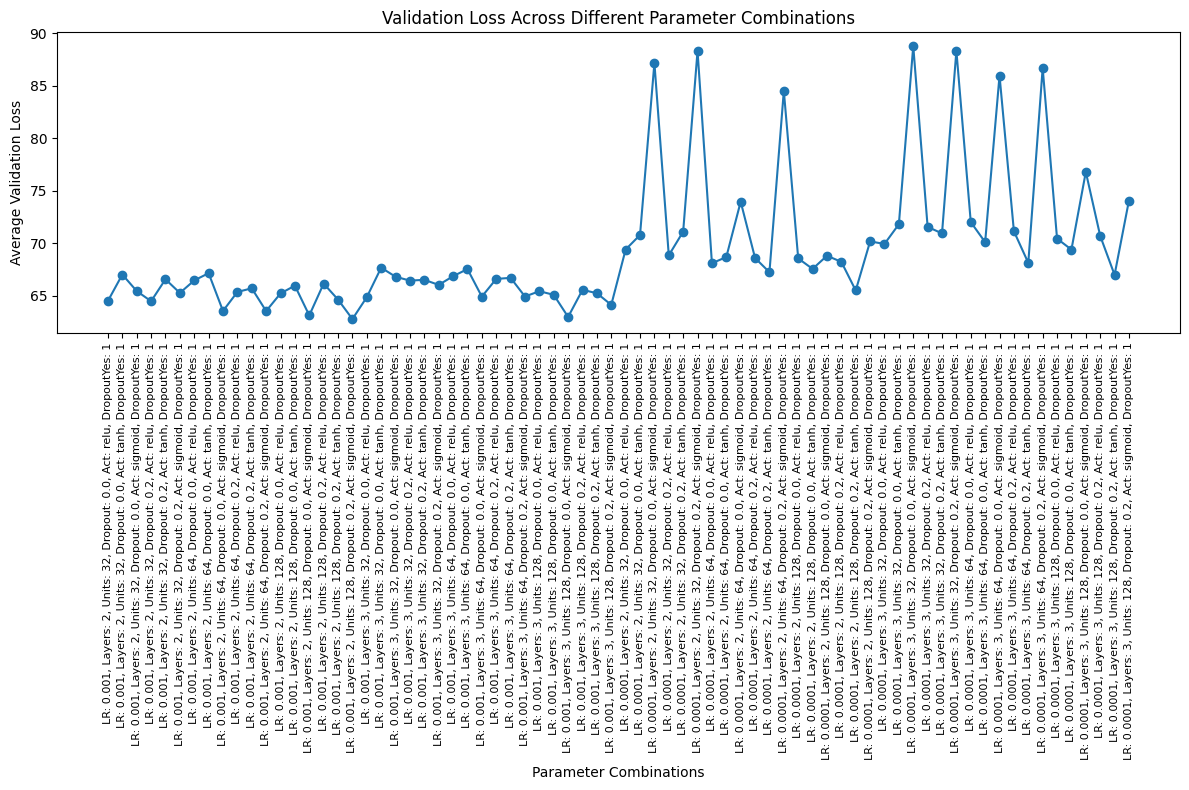

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))  # Slightly larger figure size
plt.plot(parameter_labels, avg_validation_losses, marker='o', linestyle='-')
plt.xlabel('Parameter Combinations')
plt.ylabel('Average Validation Loss')
plt.title('Validation Loss Across Different Parameter Combinations')
plt.xticks(rotation=90, fontsize=8)  # Rotate and reduce font size of x-axis labels
plt.tight_layout()  # Adjust layout to make room for label rotation
plt.show()

In [41]:
parameter_labels[np.argmin(avg_validation_losses)]
model = create_model(
            number_of_features=X_train.shape[1],
            learning_rate=0.001,
            n_layers=2,
            n_units=128,
            dropout_rate=0,
            dropoutYes=1,
            activation='relu'
        )
history = model.fit(
            X_train, [y_final_train, y_aux_train],
            validation_data=(X_val, [y_final_val, y_aux_val]),
            epochs=100,
            batch_size=16,
            verbose=0,
            callbacks=[early_stopping]
        )


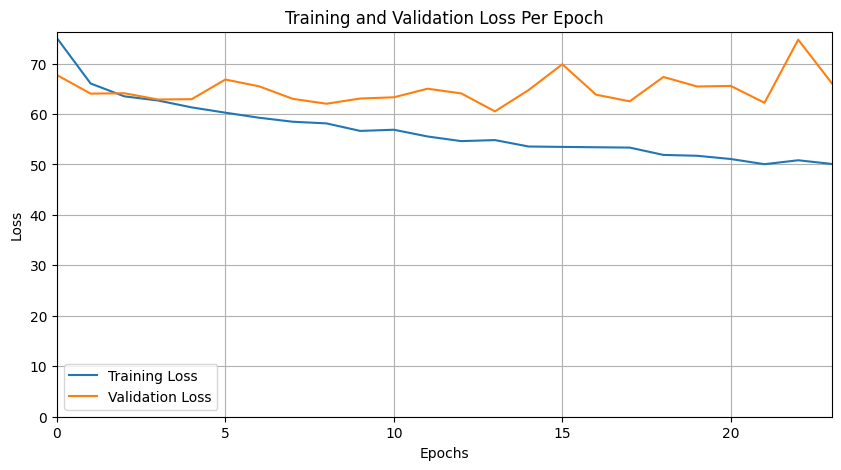

In [42]:

import matplotlib.pyplot as plt

# Assuming history is your model's history object from the fit method
training_losses = history.history['main_output_mean_squared_error']
validation_losses = history.history['val_main_output_mean_squared_error']

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss Per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(bottom=0)  # Sets the bottom of the y-axis to 0
plt.xlim(left=0, right=len(training_losses)-1)
plt.grid(True)  # Optionally add a grid for better readability
plt.show()


In [2]:
predictions = model.predict(X_test)
main_output_predictions = predictions[0]
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_final_test,main_output_predictions)

NameError: name 'model' is not defined

In [47]:
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 26.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout,BatchNormalization
from keras.optimizers import Adam
from keras import regularizers
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='mean_squared_error', patience=5, restore_best_weights=True)

def create_model(input_shape=(X_train.shape[1],), learning_rate = 0.01, nlayers = 3, nunits = 32, dropout_rate = 0.2, activation = 'relu',dropoutYes = 0,reg_lambda=0.0001):

    model = Sequential()
    model.add(Dense(nunits,activation = activation,input_shape = input_shape))
    model.add(BatchNormalization())
    for i in range(nlayers):
        model.add(Dense(nunits,activation = activation))


    if dropoutYes > 0.5:
        model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    for i in range(nlayers):
        model.add(Dense(nunits,activation = activation),kernel_regularizer=l2(reg_lambda))

    model.add(Dense(1,activation='linear'))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])

    return model

model = KerasRegressor(model=create_model, verbose=0,callbacks=early_stopping)
param_grid = {
    'model__activation': ['relu', 'tanh', 'sigmoid'],
    'model__learning_rate': [0.01, 0.001, 0.0001],
    'model__nlayers':[2,3,4],
    'model__nunits':[32,64,128],
    'model__dropoutYes':[0,1],
    'epochs': [50, 100, 200],
    'batch_size': [16, 32]
}
random_search = RandomizedSearchCV(model, param_distributions=param_grid, cv=KFold(5), random_state=42,n_jobs=-1)

random_search_results = random_search.fit(X_train, y_final_train)
print("Best Score:", random_search_results.best_score_)
print("Best Params:", random_search_results.best_params_)

NameError: name 'X_train' is not defined

In [45]:
best_model = random_search_results.best_estimator_
predictions = best_model.predict(X_val)
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_final_val, predictions)
print("Mean absolute error on validation Data:", mae)

NameError: name 'random_search_results' is not defined

In [ ]:
print("X_train shape:", X_train.shape)
print("y_final_train shape:", y_final_train.shape)
print("y_aux_train shape:", y_aux_train.shape)


In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout,BatchNormalization
from keras.optimizers import Adam
from keras import regularizers
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold

# Model building function adapted for regression with specified input shape
def create_model(learning_rate=0.01, activation='relu', input_shape=(10,)):  # Assuming input_shape is 10 for this example
    model = Sequential([
        Dense(128, activation=activation, input_shape=input_shape, kernel_regularizer=regularizers.l2(1e-5)),
        Dropout(0.5),
        BatchNormalization(),
        Dense(128, activation=activation, kernel_regularizer=regularizers.l2(1e-5)),
        Dropout(0.5),
        Dense(1, activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='mean_squared_error',
                  metrics=['mean_squared_error'])
    return model

# Wrap the model into Scikeras KerasRegressor
model = KerasRegressor(model=create_model, verbose=0)

# Setup parameter grid
param_grid = {
    'model__activation': ['relu', 'tanh', 'sigmoid', 'linear'],
    'model__learning_rate': [0.01, 0.001, 0.0001]
}

# Setup randomized search
random_search = RandomizedSearchCV(model, param_distributions=param_grid, cv=KFold(10), random_state=42)

# Example data
X_train = np.random.rand(100, 10)
y_train = np.random.rand(100)  # Continuous targets for regression

# Perform random search
random_search_results = random_search.fit(X_train, y_train)

# Access the best model, parameters, and score
print("Best Score:", random_search_results.best_score_)
print("Best Params:", random_search_results.best_params_)


